# Implementar una Red Neuronal para una Serie Temporal (LSTM)
## Introducción
La **red LSTM** (Long Sort Time Memory, diseñada por {cite:p}`hochreiter1997long`) se utiliza para predecir series temporales. Su diseño permite recordar la información durante largos períodos y facilita la tarea de hacer estimaciones futuras empleando períodos de registros históricos. Las redes LSTM usan bloques de información conectados a través de capas. Estos bloques de memoria facilitan la tarea de recordar valores para largos o cortos períodos de tiempo.

Una Red LSTM es capaz de “recordar” un dato relevante en la secuencia y de preservarlo por varios instantes de tiempo. Por tanto, puede tener una memoria tanto de corto plazo (como las Redes Recurrentes básicas) como también de largo plazo.

La red tiene una celda de estado ($c_t$) es la clave del funcionamiento de las Redes LSTM. La celda de estado es como una banda transportadora a la que se pueden añadir o de donde se pueden remover datos que no queremos que queden en la memoria de la red.

Para añadir o remover datos de esta memoria usamos varias compuertas: forget gate (que permite eliminar elementos de la memoria): 

<img src="images/LSTM_1.png" width="500px">

La update gate (que permite añadir nuevos elementos a la memoria):

<img src="images/LSTM_2.png" width="500px">

Y la compuerta de salida (que permite crear el estado oculto actualizado):

<img src="images/LSTM_3.png" width="500px">

Estas compuertas son redes neuronales que funcionan como válvulas: totalmente abiertas permiten el paso de información, y totalmente cerradas lo bloquean por completo.

Cada una de estas compuertas (o válvulas) está conformada por tres elementos: una red neuronal, una función sigmoidal y un elemento multiplicador.

La función sigmoidal es precisamente la que da a la compuerta el comportamiento de válvula, pues al alcanzar valores entre 0 y 1 permite anular por completo los valores de entrada (si la salida es 0, lo que equivale a una válvula cerrada) y permitir el paso de los mismos (si la salida es 1, lo que equivale a una válvula totalmente abierta):

<img src="images/LSTM_4.png" width="500px">

La compuerta _forget_ permite decidir qué información se va a descartar, y que por tanto no pasará a la celda de estado.

Para ello toma el estado oculto anterior y la entrada actual, los transforma y los lleva a la función de activación sigmoidal. Los coeficientes ($W_f$ y $b_f$) se aprenden durante el entrenamiento, y como salida genera el vector $f_t$:

<img src="images/LSTM_5.png" width="500px">

Si uno de los valores de este vector es 0 (o cercano a 0) entonces la LSTM eliminará esa porción de información, mientras que si alcanza valores iguales (o cercanos) a 1 esta información se mantendrá y llegará a la celda de estado.

Por ejemplo: si estamos analizando palabras dentro de un texto y entrenamos la LSTM para seguir la pista a variaciones gramaticales, podemos usar la red para detectar cambios en el sujeto de la oración, es decir si este es singular o plural.

Así, si inicialmente el sujeto es plural y luego dentro de la secuencia cambia a singular, podemos entrenar la forget gate para que detecte estas variaciones y elimine el sujeto plural, que deja de ser relevante.

Bien, ya eliminamos el sujeto plural de la memoria de la red. ¿Y cómo agregamos el singular?

Para esto usamos la “_update gate_”, que como su nombre lo indica nos permite actualizar la memoria de la celda LSTM para indicar que ahora el sujeto es singular.

Para ello, tomamos nuevamente el estado oculto anterior y la entrada actual, los transformamos y los llevamos de nuevo a una función de activación sigmoidal. También en este caso, los coeficientes ($W_i$ y $b_i$) se aprenden durante el entrenamiento, y como salida esta compuerta genera el vector $u_t$:

<img src="images/LSTM_6.png" width="500px">

En este caso, los valores que queremos preservar en la memoria de la red serán aquellos cercanos a 1.

Teniendo ya los datos generados por las compuertas forget y update, podemos ahora sí actualizar la celda de estado (es decir la memoria de la red LSTM).

__Actualización de la celda de estado__

En primer lugar eliminamos la información irrelevante de la celda de estado, multiplicando el valor anterior de esta celda por el vector generado por la compuerta forget

A continuación creamos un vector de valores candidatos a formar parte de la nueva memoria. De nuevo, los parámetros Wc y bc se aprenden durante el entrenamiento

Ahora filtramos estos valores, multiplicando punto a punto el vector que acabamos de obtener con el generado por la compuerta “update”, y el resultado lo sumamos a los valores anteriores de la celda de estado, generando así la memoria actualizada:

<img src="images/LSTM_7.png" width="500px">

__Cálculo del nuevo estado oculto__

Finalmente debemos calcular el nuevo estado oculto, para lo cual usamos la output gate o compuerta de salida.

Este estado oculto de salida es simplemente una versión filtrada del estado de la celda que acabamos de generar.

En primer lugar escalamos el nuevo “cell state” para garantizar que esté en el rango de -1 a 1 (el rango que tiene precisamente el estado oculto). Para ello usamos la función tangente hiperbólica.

Ahora, usamos la compuerta de salida para determinar qué porciones del cell-state entrarán a formar parte del nuevo estado oculto. Al igual que en los casos anteriores, los parámetros Wo y bo serán aprendidos durante el entrenamiento.

Y finalmente, filtramos los valores del cell-state con el vector generado por la compuerta de salida:

<img src="images/LSTM_8.png" width="500px">

A la hora de implementar las redes LSTM con pyTorch, nos vamos a encontrar con la ventaja de disponer de una función sintética que lo resuelve (__nn.LSTM__)

In [2]:
from skimage import io
from skimage.transform import resize
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt 

import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
%matplotlib inline

In [3]:
googleColaboratory=False
entrenamiento=True

## Conexión con el sistema de archivos
- Se carga un fichero CSV con el dato de la serie temporal. Número de transacciones diarias
- Se muestra el aspecto que tiene la serie temporal

In [4]:
if googleColaboratory:
    from google.colab import drive
    drive.mount('/content/drive/')
    rootFiles="/content/drive/My Drive/Colab Notebooks/data"
else:
    rootFiles="./data"

In [5]:
df = pd.read_csv(rootFiles+'/transactions_one.csv', header=None, sep=';')
df.columns = ['NumDia', 'Trans']
df.head()

,NumDia,Trans
0,1,0.123048
1,2,0.110922
2,3,0.106618
3,4,0.019243
4,5,0.013647


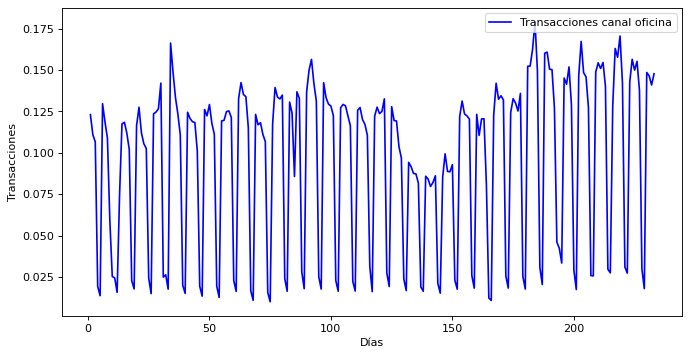

In [6]:
dias = df["NumDia"]
numtrans = df["Trans"]
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(dias, numtrans, c='b', label="Transacciones canal oficina")
plt.xlabel("Días")
plt.ylabel("Transacciones")
plt.legend(loc='upper right')
plt.show()

## Proceso de Datos
Preparamos los datos para usarlos en el entrenamiento de la red:
- Se toma la lista de número de ejecuciones
- Se separa en Entrenamiento y Prueba
- Se crean bloques de 7 días para construir los tensores que entrenarán la red

In [7]:
## Volcamos los datos de las transacciones
all_data = df['Trans'].values.astype(float)
## Creamos el set de Entrenamiento y Pruebas
test_data_size = 20

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data), len(test_data))
print(test_data)

213 20
[0.02963  0.027467 0.128498 0.163018 0.157705 0.170548 0.142233 0.030978
 0.027295 0.142757 0.15649  0.149921 0.15524  0.137721 0.029843 0.017913
 0.148521 0.146414 0.140943 0.147745]


In [8]:
## Se convierte el dato de entrada en tensor
train_data = torch.FloatTensor(train_data).view(-1)
test_data = torch.FloatTensor(test_data).view(-1)
test_data

tensor([0.0296, 0.0275, 0.1285, 0.1630, 0.1577, 0.1705, 0.1422, 0.0310, 0.0273,
        0.1428, 0.1565, 0.1499, 0.1552, 0.1377, 0.0298, 0.0179, 0.1485, 0.1464,
        0.1409, 0.1477])

In [9]:
## Se crean secuencias en los datos. Secuencia relacionada con la estructura de la serie temporal
## Adoptamos secuencias de 7 días, por tener una estacionalidad semanal y ser un dato diario
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [10]:
## Ejecutamos la función anterior bajo una secuencia 7 en nuestros datos:
train_window = 7
train_inout_seq = create_inout_sequences(train_data, train_window)
train_inout_seq[1:3], train_data[1:20]

([(tensor([0.1109, 0.1066, 0.0192, 0.0136, 0.1297, 0.1186, 0.1090]),
   tensor([0.0590])),
  (tensor([0.1066, 0.0192, 0.0136, 0.1297, 0.1186, 0.1090, 0.0590]),
   tensor([0.0252]))],
 tensor([0.1109, 0.1066, 0.0192, 0.0136, 0.1297, 0.1186, 0.1090, 0.0590, 0.0252,
         0.0244, 0.0157, 0.0744, 0.1175, 0.1184, 0.1119, 0.1019, 0.0228, 0.0178,
         0.1163]))

## Crear el modelo LSTM
**input_size**: Es el número de características en la entrada. Aunque la longitud de nuestra secuencia es 7, para cada semana solo se tiene 1 valor, es decir, el número total de ejecuciones, por lo tanto, el tamaño de entrada será 1.

**hidden_layer_size**: especifica el número de capas ocultas junto con el número de neuronas en cada capa. Tendremos una capa de 100 neuronas.

**output_size**: La cantidad de elementos en la salida, ya que queremos predecir la cantidad de ejecuciones para 1 semana en el futuro, el tamaño de la salida será 1.

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    

### Creación del objeto LSTM() y definir función de optimización

In [12]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## Entrenamiento de la Red
Se hará un entrenamiento de 150 épocas. Se imprimirá el error o pérdida cada 25 épocas

In [13]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00169872
epoch:  26 loss: 0.00050499
epoch:  51 loss: 0.00039711
epoch:  76 loss: 0.00057291
epoch: 101 loss: 0.00118167
epoch: 126 loss: 0.00095613
epoch: 149 loss: 0.0003635629


## Predicciones a futuro

In [19]:
## Como estamos prediciendo por semanas vamos a ver los valores que se tiene de las últimas 7 semanas
fut_pred = 7

pred_inputs = train_data[-train_window:].tolist()
print(pred_inputs)
pred_inputs

[0.025825999677181244, 0.025638999417424202, 0.14882799983024597, 0.15433600544929504, 0.15092100203037262, 0.15455999970436096, 0.14014199376106262]


[0.025825999677181244,
 0.025638999417424202,
 0.14882799983024597,
 0.15433600544929504,
 0.15092100203037262,
 0.15455999970436096,
 0.14014199376106262]

In [20]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(pred_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        pred_inputs.append(model(seq).item())

In [21]:
### Una secuencia de 7 valores pre-existentes y 7 valores predichos
pred_inputs

[0.025825999677181244,
 0.025638999417424202,
 0.14882799983024597,
 0.15433600544929504,
 0.15092100203037262,
 0.15455999970436096,
 0.14014199376106262,
 0.046856172382831573,
 0.013356514275074005,
 0.1544228494167328,
 0.12653619050979614,
 0.14323008060455322,
 0.14925652742385864,
 0.11354171484708786]

In [22]:
print(len(all_data), len(train_data), len(test_data), len(pred_inputs))
all_days = df["NumDia"]
train_days = np.linspace(1, len(train_data), len(train_data))
#test_days = np.linspace(len(train_data)+1, len(train_data) + len(test_data), len(test_data))
pred_days = np.linspace(len(train_data)-len(pred_inputs)+8, len(train_data)+7, len(pred_inputs))
pred_days, len(pred_days)

233 213 20 14


(array([207., 208., 209., 210., 211., 212., 213., 214., 215., 216., 217.,
        218., 219., 220.]),
 14)

## Se muestran las predicciones en el contexto de la serie completa
- El conjunto de Pruebas está en la parte final de la serie 
- La predicción se hace en un bloque de 7 días al principio del bloque de pruebas
- Se muestra la serie de entranamiento (hasta el día 213)
- Y la predicción se comprueba con la serie real que acaba en el día 233
- La serie real completa se muestra en azul
- La predicción en rojo para poder comparar

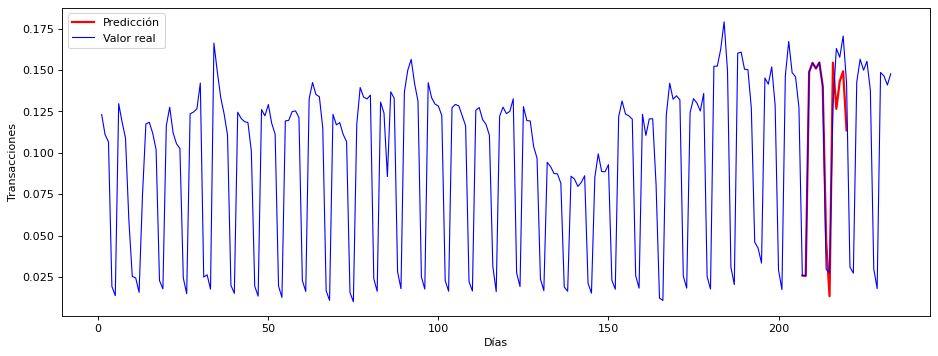

In [23]:
plt.figure(figsize=(14, 5), dpi=80)
plt.plot(pred_days, pred_inputs, c='r', linewidth=2.0, label="Predicción")
plt.plot(df["NumDia"], df["Trans"], c='b', linewidth=1.0, label="Valor real")
plt.xlabel("Días")
plt.ylabel("Transacciones")
plt.legend(loc='upper left')
plt.show()